**Step 1: Import Libraries**

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

**Step 2: Load Dataset and Check info**

In [3]:
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv", header=0)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.shape

(32561, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [7]:
display(df.describe(include=[np.number]).T)

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


**CONFIG**

In [8]:
TARGET = "income"
RANDOM_STATE = 42
TEST_SIZE = 0.2

**Step 3: Exploratory Data Analysis (EDA)**

**Class Distribution**

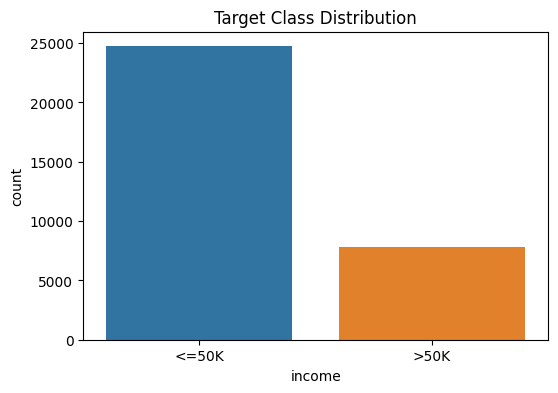

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=TARGET, data=df)
plt.title("Target Class Distribution")
plt.show()

**Histograms for Numeric Columns**

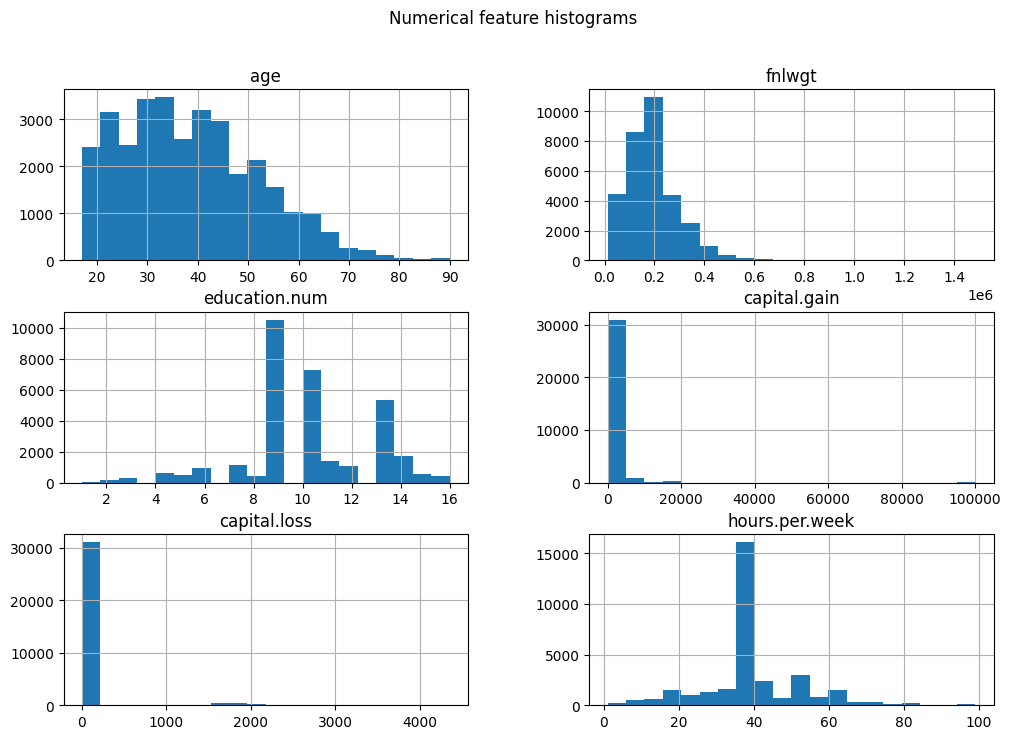

In [10]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if num_cols:
    df[num_cols].hist(figsize=(12, 8), bins=20)
    plt.suptitle("Numerical feature histograms")
    plt.show()

**Correlation heatmap (numerical only)**

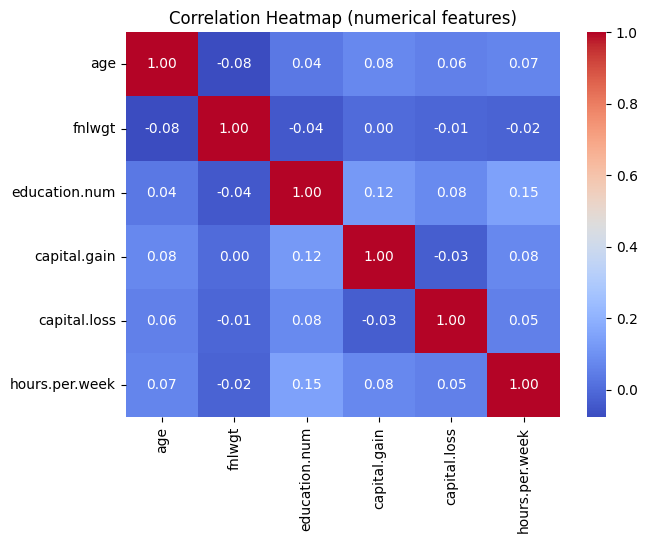

In [11]:
if len(num_cols) >= 2:
    plt.figure(figsize=(7,5))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap (numerical features)")
    plt.show()

**Top categorical value counts for some categorical features**

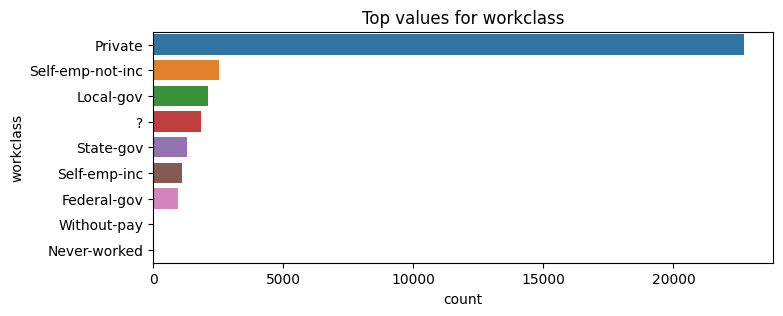

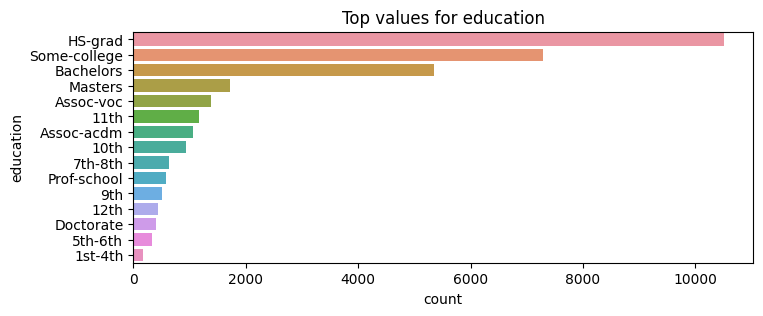

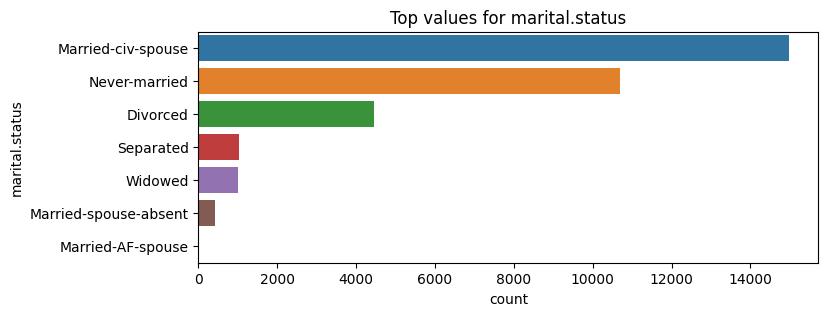

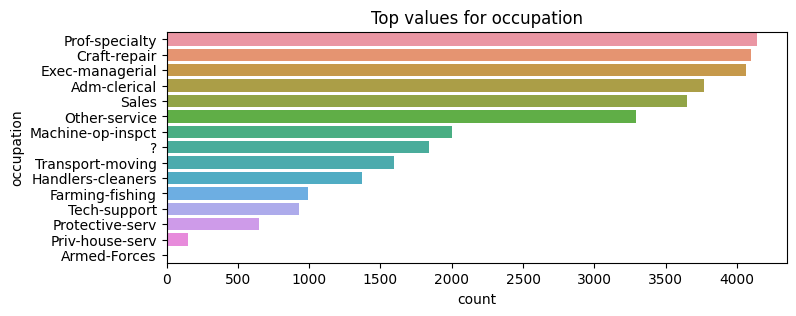

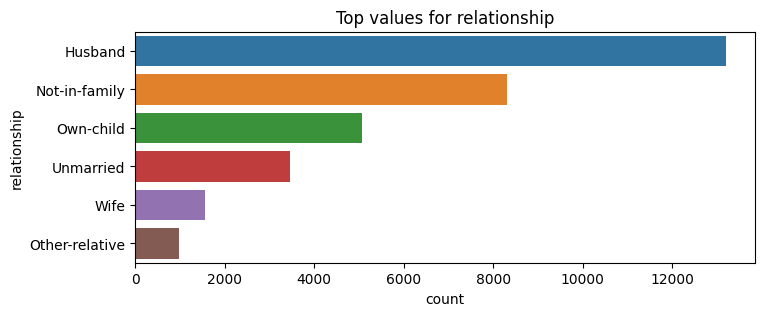

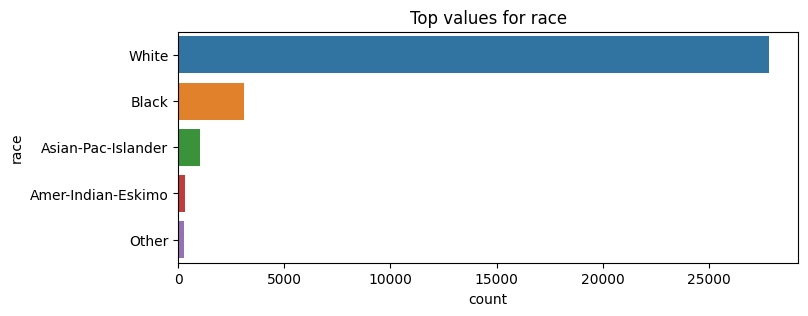

In [12]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != TARGET]
for c in cat_cols[:6]:
    plt.figure(figsize=(8,3))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index[:15])
    plt.title(f"Top values for {c}")
    plt.show()

In [13]:
df = df.replace('?', np.nan)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


**Step 4: Feature Engineering**

In [14]:
if set(['capital-gain', 'capital-loss']).issubset(df.columns):
    df['capital_net'] = df['capital-gain'].fillna(0) - df['capital-loss'].fillna(0)

if 'age' in df.columns:
    df['age_bin'] = pd.cut(df['age'], bins=[0,25,40,60,100], labels=['young','adult','mid','senior'])

if 'education' in df.columns:
    def edu_group(x):
        x = str(x).lower()
        if 'bachelors' in x or 'master' in x or 'doctor' in x:
            return 'higher'
        elif '11th' in x or '9th' in x or '7th' in x or '10th' in x or '12th' in x:
            return 'school'
        else:
            return 'other'
    df['education_group'] = df['education'].apply(lambda x: edu_group(x) if pd.notna(x) else x)


In [15]:
print("\nMissing values after '?' replacement:")
display(df.isna().sum().sort_values(ascending=False).head(10))


Missing values after '?' replacement:


occupation        1843
workclass         1836
native.country     583
age                  0
capital.gain         0
age_bin              0
income               0
hours.per.week       0
capital.loss         0
race                 0
dtype: int64

**Step 5: Data Preprocessing**

In [16]:
y_raw = df[TARGET].copy()

def encode_binary_target(series):
    if series.dtype.kind in 'biu' and set(series.unique()).issubset({0,1}):
        return series.astype(int)

    s = series.astype(str).str.strip()
    if s.str.contains('>').any() or s.str.contains('50K').any():
        return s.apply(lambda x: 1 if ('>' in x and '50' in x) or ('50K' in x and '>' in x) or ('>50K' in x or '>50K.' in x) else 0).astype(int)
    
    le = LabelEncoder()
    vals = le.fit_transform(series.astype(str))
    if len(np.unique(vals)) == 2:
        return pd.Series(vals, index=series.index).astype(int)
    else:
        raise ValueError("Target appears not binary. Provide binary classification target.")

y = encode_binary_target(y_raw)
print("\nEncoded target class counts:")
display(pd.Series(y).value_counts())


Encoded target class counts:


income
0    24720
1     7841
Name: count, dtype: int64

**Drop rows where target is missing**

In [17]:
mask_non_null_target = y_raw.notna()
X = df.loc[mask_non_null_target].drop(columns=[TARGET]).copy()
y = y[mask_non_null_target]

In [18]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

if 'age_bin' in X.columns and 'age_bin' not in categorical_features:
    categorical_features.append('age_bin')
if 'education_group' in X.columns and 'education_group' not in categorical_features:
    categorical_features.append('education_group')

print("\nNumerical features:", numeric_features)
print("Categorical features (sample):", categorical_features[:10])


Numerical features: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Categorical features (sample): ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'age_bin', 'education_group']


**Preprocessing pipelines**

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

from sklearn.pipeline import make_pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop', sparse_threshold=0)

**Step 6: Train-Test Split**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("\nTrain - Test sizes:", X_train.shape, X_test.shape)


Train - Test sizes: (26048, 16) (6513, 16)


**Step 7: Defined Models**

In [21]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "KNeighbors": KNeighborsClassifier(),
    "GaussianNB": GaussianNB()
    # "SVC": SVC(probability=True, random_state=RANDOM_STATE)
}
if has_xgb:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)


**Step 8: Train Untuned Models and Evaluate**

In [22]:
untuned_results = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('clf', clf)])
    try:
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        probas = None
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            try:
                probas = pipe.predict_proba(X_test)[:, 1]
            except Exception:
                probas = None
        elif hasattr(pipe.named_steps['clf'], "decision_function"):
            try:
                probas = pipe.decision_function(X_test)
            except Exception:
                probas = None
        
        acc = accuracy_score(y_test, preds)
        roc_auc = roc_auc_score(y_test, probas) if probas is not None else np.nan
        cm = confusion_matrix(y_test, preds)
        cls_report = classification_report(y_test, preds)
        
        untuned_results[name] = {
            "pipeline": pipe,
            "preds": preds,
            "probas": probas,
            "accuracy": acc,
            "roc_auc": roc_auc,
            "confusion_matrix": cm,
            "classification_report": cls_report
        }
    except Exception as e:
        print(f"Failed {name}: {e}")

print("\nUntuned model accuracies:")
sorted_untuned_results = sorted(untuned_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for name, res in sorted_untuned_results:
    print(f"{name}: Accuracy = {res['accuracy']:.4f}")

print("\n")
best_untuned_name, best_untuned_res = sorted_untuned_results[0]
print(f"Best untuned model: {best_untuned_name} (accuracy {best_untuned_res['accuracy']:.4f})")
best_untuned_pipe = best_untuned_res['pipeline']


Untuned model accuracies:
XGBoost: Accuracy = 0.8698
GradientBoosting: Accuracy = 0.8617
LogisticRegression: Accuracy = 0.8523
RandomForest: Accuracy = 0.8518
KNeighbors: Accuracy = 0.8306
DecisionTree: Accuracy = 0.8167
GaussianNB: Accuracy = 0.5601


Best untuned model: XGBoost (accuracy 0.8698)


**ROC Curves for all Untuned Models**

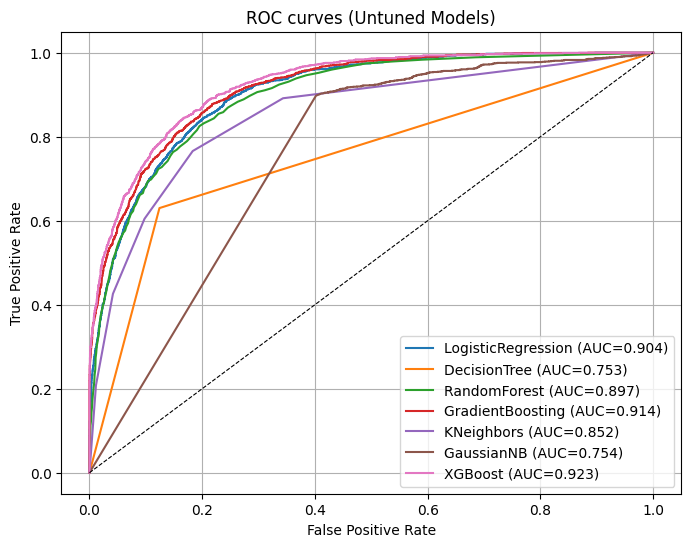

In [23]:
plt.figure(figsize=(8,6))
for name, res in untuned_results.items():
    if res['probas'] is not None and not np.isnan(res['roc_auc']):
        fpr, tpr, _ = roc_curve(y_test, res['probas'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--', lw=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (Untuned Models)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Confusion Matrix & Classification Report for best Untuned Model**


Confusion matrix for best untuned model: XGBoost


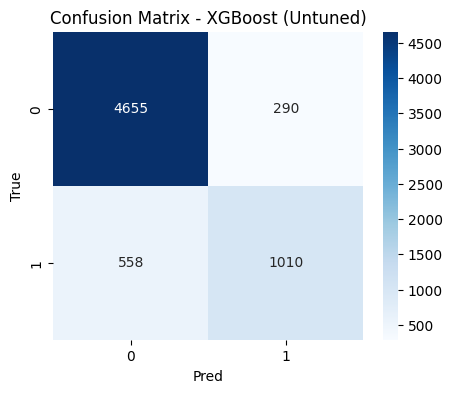


Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4945
           1       0.78      0.64      0.70      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



In [24]:
print(f"\nConfusion matrix for best untuned model: {best_untuned_name}")
cm = untuned_results[best_untuned_name]['confusion_matrix']
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Pred")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_untuned_name} (Untuned)")
plt.show()

print("\nClassification report:")
print(untuned_results[best_untuned_name]['classification_report'])

**Step 9: Hyperparameter tuning (RandomizedSearchCV)**

In [25]:
param_distributions = {
    "LogisticRegression": {'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'], 'clf__solver': ['liblinear','saga']},
    "DecisionTree": {'clf__max_depth': [None, 5, 10, 20], 'clf__min_samples_split': [2, 5, 10]},
    "RandomForest": {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20],'clf__min_samples_split': [2, 5]},
    "GradientBoosting": {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.05, 0.1], 'clf__max_depth': [3,5,8]},
    "KNeighbors": {'clf__n_neighbors': [3,5,7,9],'clf__weights': ['uniform', 'distance']},
    "GaussianNB": {'clf__var_smoothing': [1e-9, 1e-8, 1e-7]}
}
if has_xgb:
    param_distributions["XGBoost"] = {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [3,6,10], 'clf__learning_rate': [0.01,0.1,0.2]
    }

**Train Tuned Models and Evaluate**

In [26]:
tuned_results = {}
n_iter_search = 20

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('clf', clf)])
    param_dist = param_distributions[name]

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=min(n_iter_search, max(1, len(param_dist) * 3)),
        scoring='accuracy',
        n_jobs=-1,
        cv=3,
        random_state=RANDOM_STATE,
        verbose=0
    )

    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_
    preds = best_pipe.predict(X_test)

    probas = None
    if hasattr(best_pipe.named_steps['clf'], "predict_proba"):
        try:
            probas = best_pipe.predict_proba(X_test)[:, 1]
        except Exception:
            probas = None
    elif hasattr(best_pipe.named_steps['clf'], "decision_function"):
        try:
            probas = best_pipe.decision_function(X_test)
        except Exception:
            probas = None

    acc = accuracy_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probas) if probas is not None else np.nan
    cm = confusion_matrix(y_test, preds)
    cls_report = classification_report(y_test, preds)

    tuned_results[name] = {
        "pipeline": best_pipe,
        "preds": preds,
        "probas": probas,
        "accuracy": acc,
        "roc_auc": roc_auc,
        "confusion_matrix": cm,
        "classification_report": cls_report,
        "best_params": search.best_params_,
        "cv_best_score": search.best_score_
    }

print("\nTuned model accuracies:")
sorted_tuned_results = sorted(tuned_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for name, res in sorted_tuned_results:
    print(f"{name}: Accuracy = {res['accuracy']:.4f}")

best_tuned_name, best_tuned_res = sorted_tuned_results[0]
print(f"Best tuned model: {best_tuned_name} (accuracy {best_tuned_res['accuracy']:.4f})")
best_tuned_pipe = best_tuned_res['pipeline']

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Tuned model accuracies:
XGBoost: Accuracy = 0.8700
GradientBoosting: Accuracy = 0.8689
RandomForest: Accuracy = 0.8638
DecisionTree: Accuracy = 0.8544
LogisticRegression: Accuracy = 0.8524
KNeighbors: Accuracy = 0.8354
GaussianNB: Accuracy = 0.6057
Best tuned model: XGBoost (accuracy 0.8700)


**ROC Curves for all Tuned Models**

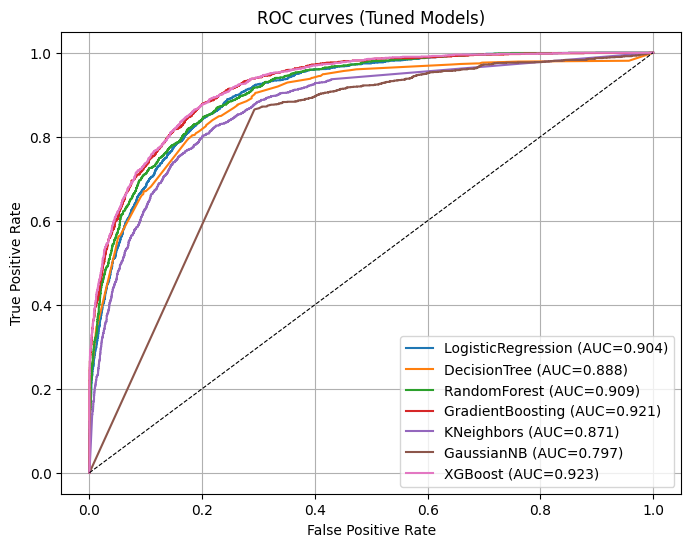

In [27]:
plt.figure(figsize=(8,6))
for name, res in tuned_results.items():
    if res['probas'] is not None and not np.isnan(res['roc_auc']):
        fpr, tpr, _ = roc_curve(y_test, res['probas'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--', lw=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (Tuned Models)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Confusion Matrix & Classification Report for best tuned model**


Confusion matrix for best tuned model: XGBoost


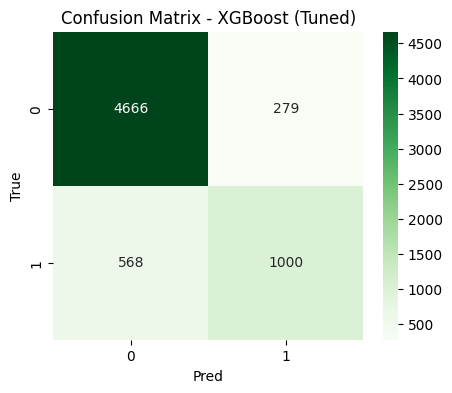


Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4945
           1       0.78      0.64      0.70      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



In [28]:
print(f"\nConfusion matrix for best tuned model: {best_tuned_name}")
cm = tuned_results[best_tuned_name]['confusion_matrix']
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Pred")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_tuned_name} (Tuned)")
plt.show()

print("\nClassification report:")
print(tuned_results[best_tuned_name]['classification_report'])


**Step 10: Accuracy Comparison**

In [29]:
comparison_rows = []
for name in sorted(set(list(untuned_results.keys()) + list(tuned_results.keys()))):
    unt_acc = untuned_results[name]['accuracy'] if name in untuned_results else np.nan
    tun_acc = tuned_results[name]['accuracy'] if name in tuned_results else np.nan
    comparison_rows.append({"model": name, "untuned_accuracy": unt_acc, "tuned_accuracy": tun_acc})
    
comparison_df = pd.DataFrame(comparison_rows).sort_values(by=['tuned_accuracy','untuned_accuracy'], ascending=False).reset_index(drop=True)
print("\nAccuracy Comparison (Untuned vs Tuned):")
display(comparison_df)


Accuracy Comparison (Untuned vs Tuned):


,model,untuned_accuracy,tuned_accuracy
0,XGBoost,0.869799,0.869952
1,GradientBoosting,0.861661,0.868878
2,RandomForest,0.851835,0.863811
3,DecisionTree,0.816674,0.854445
4,LogisticRegression,0.852295,0.852449
5,KNeighbors,0.830646,0.835406
6,GaussianNB,0.560111,0.605712


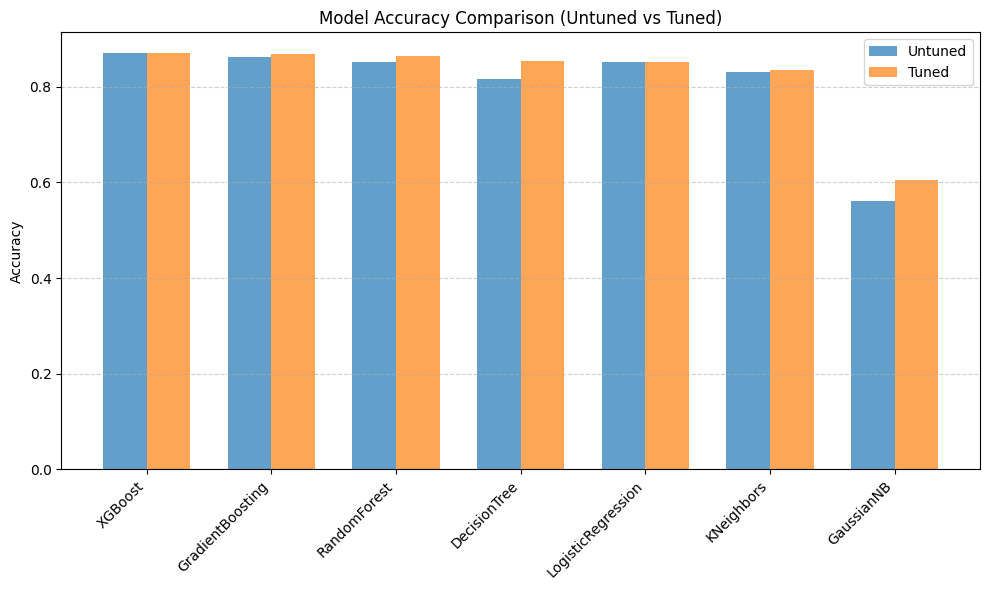

In [30]:
comparison_df_sorted = comparison_df.sort_values(by=['tuned_accuracy','untuned_accuracy'], ascending=False)

x = np.arange(len(comparison_df_sorted['model']))  
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, comparison_df_sorted['untuned_accuracy'], width, label='Untuned', alpha=0.7)
ax.bar(x + width/2, comparison_df_sorted['tuned_accuracy'], width, label='Tuned', alpha=0.7)

ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison (Untuned vs Tuned)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df_sorted['model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Step 11: Prediction Comparison**

In [31]:
untuned_best_pred = untuned_results[best_untuned_name]['preds']
tuned_best_pred = tuned_results[best_tuned_name]['preds']

pred_df = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    f"Untuned_{best_untuned_name}": untuned_best_pred,
    f"Tuned_{best_tuned_name}": tuned_best_pred
})

print("\nPrediction Comparison:")
display(pred_df.head(10))


Prediction Comparison:


,Actual,Untuned_XGBoost,Tuned_XGBoost
0,0,0,0
1,0,0,0
2,1,1,1
3,1,1,0
4,0,0,0
5,0,0,1
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0
